In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [38]:
# ---== wave vector generation ==--- #

# I have made multiple versions to generate the wave vectors for testing
# The deprecated ones are not to be used. Note also we always assume the domain is [0, 1]^2

def generate_k_vectors(K, num_per_dim=10):
    """
    Generate wavevectors with |k| < kmax
    on a uniform 2D grid using fftfreq
    """
    max_threshhold = 1.2*K**2
    min_threshhold = np.pi**2

    kx = np.fft.fftfreq(num_per_dim, d=1.0/num_per_dim) * 2 * np.pi
    ky = np.fft.fftfreq(num_per_dim, d=1.0/num_per_dim) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    k_flat = np.stack((kx.ravel(), ky.ravel()), axis=0)
    
    # Apply radial cutoff
    mag_k = np.sum(k_flat*k_flat, axis=0)
    mask = (mag_k > min_threshhold) & (mag_k < max_threshhold)
    return k_flat[:, mask]  # shape: (2, nk)


def grid_k_vectors(K, max_n=20):
    """
    Generate wavevectors with |k| < kmax
    on a uniform 2D grid with rejection sampling
    """
    max_threshhold = 1.2*K**2
    min_threshhold = np.pi**2

    k_list = []
    for nx in range(-max_n, max_n+1, 2):
        for ny in range(-max_n, max_n+1, 2):
            if nx == 0 and ny == 0:
                continue
            k = 2 * np.pi * np.array([nx, ny])
            mag = np.sum(k*k)
            if  mag > min_threshhold and mag < max_threshhold:
                k_list.append(k)
    return np.array(k_list).T # shape : (2, nk)

In [39]:
# ---== inital point pattern generation ==--- #

# Important: the domain is always [0, 1]^2

def random_point_pattern(N):
    return np.random.uniform(0, 1, size=(N, 2)) # shape : (rN, 2)

# ------
# the following methods generate approximately N points and exactly N points if N = k^2, for some k

def uniform_point_pattern(N):
    rN = round(np.sqrt(N))
    space = np.linspace(0.01, .99, rN)
    return np.array(np.meshgrid(space, space)).reshape(2, -1).T # shape : (rN, 2)

def perturbed_point_pattern(N, eps=0.005):
    uniform = uniform_point_pattern(N)
    rN = uniform.shape[0]
    pert_x = eps*np.random.uniform(-1, 1, size=(rN,))
    pert_y = eps*np.random.uniform(-1, 1, size=(rN,))
    uniform[:, 0] += pert_x
    uniform[:, 1] += pert_y
    return uniform  # shape : (rN, 2)

In [ ]:
# for optimization pruposes
def compute_rho_exp(exp_k_dot_r):
    return np.sum(exp_k_dot_r, axis=0)  # (M,)

def compute_rho_dot(k_dot_r):
    return np.sum(np.exp(1j * k_dot_r), axis=0)  # (M,)

def compute_rho(k, r):
    N = r.shape[0]
    k_dot_r = np.tensordot(r, k, axes=([1], [0]))  # (N, M)
    return np.sum(np.exp(1j * k_dot_r), axis=0)  # (M,)

# for optimization purposes
def compute_S_rho(rho, N):
    return np.abs(rho)**2 / N

def compute_S(k, r):
    N = r.shape[0]
    return np.abs(compute_rho(k, r))**2 / N

def compute_S0(k, D, H, alpha, K_cutoff):
    k_magnitude = np.linalg.norm(k, axis=0)  # (M,)
    S0 = np.where(k_magnitude < K_cutoff, D * (1 - H) * (k_magnitude**alpha) + H, 1.0)
    return S0

def objective_function(x, k, D, H, alpha, K_cutoff):
    N = x.shape[0] // 2
    r = x.reshape(N, 2)
    r = np.mod(r, 1.0)
    S_kr = compute_S(k, r)
    S0_k = compute_S0(k, D, H, alpha, K_cutoff)
    return np.sum((S_kr - S0_k)**2)

def gradient_function(x, k, D, H, alpha, K_cutoff):
    N = x.shape[0] // 2
    r = x.reshape(N, 2)
    r = np.mod(r, 1.0)
    grad = np.zeros_like(r) # (N, 2)
    k_dot_r = r[:, :, None] * k[None, :, :]  # (N, 2, M)
    exp_k_dot_r = np.exp(1j * k_dot_r) # (N, 2, M)
    rho = compute_rho_exp(np.sum(exp_k_dot_r, axis=1)) # (M,)
    S_kr = compute_S_rho(rho, N) # (M,)
    S0_k = compute_S0(k, D, H, alpha, K_cutoff) # (M,)
    term = (-4j/N) * k * ((S_kr - S0_k) * rho) # (2, M)
    Ck_hat = np.sum( term * exp_k_dot_r, axis=2) # (N, 2)
    grad[:, 0] = np.fft.ifft(Ck_hat[:, 0]).real
    grad[:, 1] = np.fft.ifft(Ck_hat[:, 1]).real
    return grad.flatten()

In [41]:
# ---== Visualization ==--- #

def plot_wave_vectors(k):
    plt.figure(figsize=(6, 6))
    plt.scatter(k[0, :], k[1, :], marker="x", color="green")
    plt.xlabel("$k_x$")
    plt.ylabel("$k_y$")
    plt.title("Wave vectors")
    plt.show()

def plot_particles(r, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(r[:, 0], r[:, 1], c="blue", s=20)
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.show()

def plot_structure_factor(r, k, D, H, alpha, K_cutoff, title):
    S_kr = compute_S(k, r)
    S_0_k = compute_S0(k, D, H, alpha, K_cutoff)
    k_magnitude = np.linalg.norm(k, axis=0)
    plt.figure(figsize=(8, 5))
    plt.scatter(k_magnitude/K_cutoff, S_kr, color="red", label="Computed S(k)")
    plt.scatter(k_magnitude/K_cutoff, S_0_k, color="green", label="Computed S_0(k)", marker="x")
    plt.xlabel("|k|")
    plt.ylabel("S(k)")
    plt.title(title)
    plt.legend()
    plt.show()

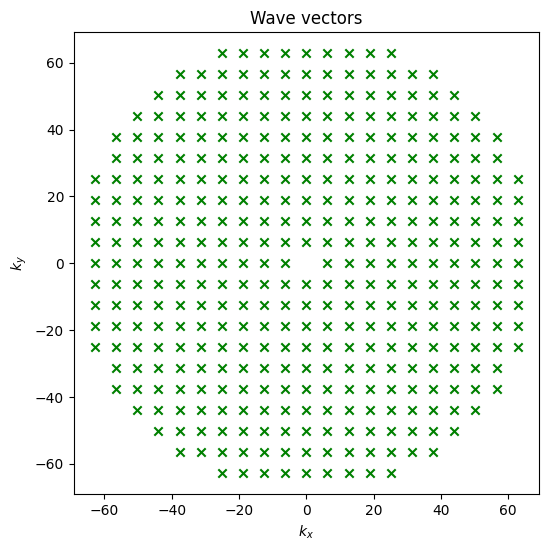

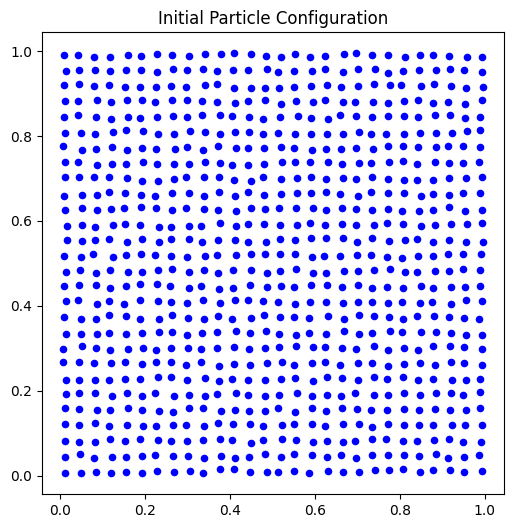

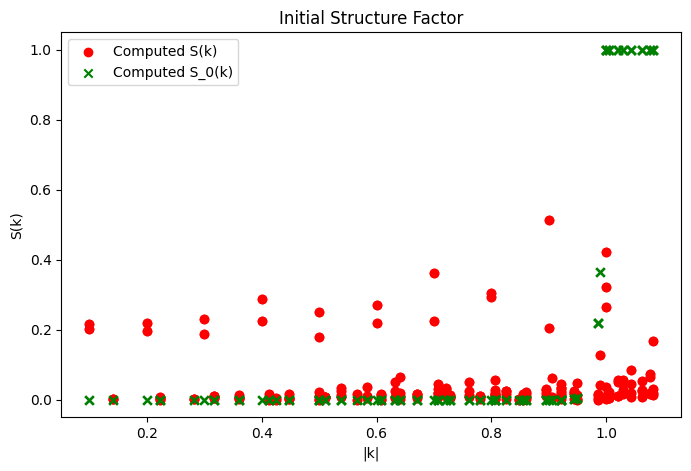

Value before optimizing:  63.92805003709617
         Current function value: 63.928050
         Iterations: 0
         Function evaluations: 70
         Gradient evaluations: 58
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 63.92805003709617
        x: [ 1.049e-02  6.024e-03 ...  9.932e-01  9.873e-01]
      nit: 0
      jac: [ 6.241e+03 -2.376e+03 ...  2.263e+03 -2.413e+03]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 70
     njev: 58
parameters saved to parms.csv
phi saved to point_patterns/pp.npy


c:\Users\eioer\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


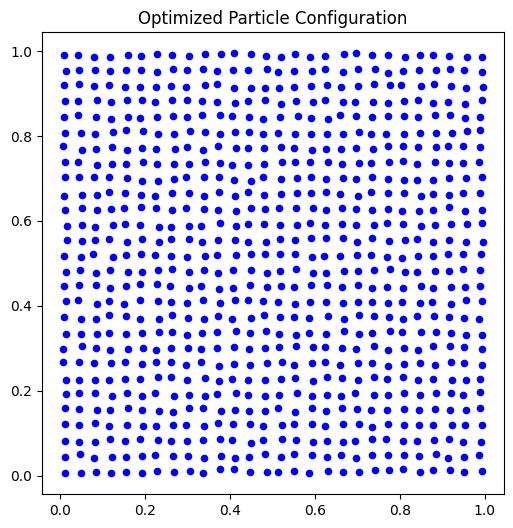

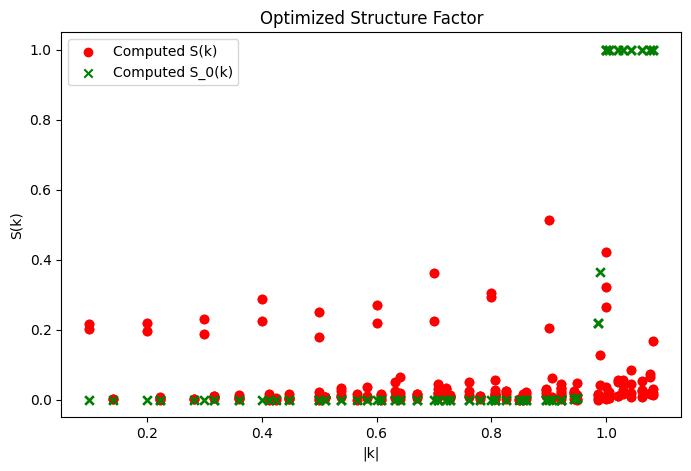

In [42]:
np.random.seed(0)  # For reproducibility

# ---== Parameters ==--- #

N = 780
M = 100     

# Target structure factor parameters
H = 1e-4
alpha = 100.
K_cutoff = 20*np.pi
D = np.pow(K_cutoff, -alpha)

r_init = perturbed_point_pattern(N)
# since some point pattern generation algos dont give exactly N
N = r_init.shape[0] 

k = generate_k_vectors(K_cutoff,num_per_dim=M)
#k = grid_k_vectors(K_cutoff)
M = k.shape[1]

# Plot wave vectors used:
plot_wave_vectors(k)

# Plot before optimization
plot_particles(r_init, "Initial Particle Configuration")
plot_structure_factor(r_init, k, D, H, alpha, K_cutoff, "Initial Structure Factor")

print("Value before optimizing: ", objective_function(r_init.flatten(), k, D, H, alpha, K_cutoff))

# ---== Run Optimization ==--- #
res = minimize(
    fun=objective_function,
    x0=r_init.flatten(),
    jac=gradient_function,
    args=(k, D, H, alpha, K_cutoff),
    method="BFGS",
    options={"disp": True, "maxiter": 1000},
    tol=1e-8
)

# ---== Postprocess ==--- #

r_opt = res.x.reshape(N, 2)  # Final particle positions
print(res)

# Save point pattern:
outfile = f"point_patterns/pp.npy"
np.save(outfile, r_opt)
with open("point_patterns/parms.csv", 'w') as f:
        f.write("N, M, D, H, K_cutoff, alpha\n")
        f.write(f"{N},{M},{D},{H},{K_cutoff},{alpha}\n")
print("parameters saved to parms.csv")
print(f"phi saved to {outfile}")

# Plot after optimization
plot_particles(r_opt, "Optimized Particle Configuration")
plot_structure_factor(r_opt, k, D, H, alpha, K_cutoff, "Optimized Structure Factor")
